In [49]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Cleanse text data





In [50]:
# Convert all words to lowercase
df["review"] = df["review"].str.lower()

# Remove HTML tags using Beautiful soup
from bs4 import BeautifulSoup
df["review"] = df["review"].apply(lambda review: BeautifulSoup(review, "lxml").text)

# Remove urls
# From https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python
import re
df["review"] = df["review"].apply(lambda review: re.sub(r'^https?:\/\/.*[\r\n]*', '', review, flags=re.MULTILINE))

df.head()

<ipython-input-50-6e751ea85957>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df["review"] = df["review"].apply(lambda review: BeautifulSoup(review, "lxml").text)


,review,sentiment,num_words
0,one of the other reviewers has mentioned that ...,positive,308
1,a wonderful little production. the filming tec...,positive,156
2,i thought this was a wonderful way to spend ti...,positive,164
3,basically there is a family where a little boy...,negative,135
4,"petter mattei's ""love in the time of money"" is...",positive,222


In [51]:
pip install contractions

In [52]:
# Remove Contractions
import contractions
df["review"] = df["review"].apply(lambda review: contractions.fix(review))

Classify text after converting response variable

In [53]:
#Create Word Cloud
from wordcloud import WordCloud, STOPWORDS

all_reviews = " "
positive_reviews = " "
negative_reviews =  ""

stopwords = set(STOPWORDS)


positive_df = df[df["sentiment"]  == "positive"]
negative_df = df[df["sentiment"]  == "negative"]

for review in positive_df.review:
    # Tokenize the review
    tokens = review.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    all_reviews += " ".join(tokens)+" "
    positive_reviews  += " ".join(tokens)+" "

for review in negative_df.review:
    # Tokenize the review
    tokens = review.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    all_reviews += " ".join(tokens)+" "
    negative_reviews  += " ".join(tokens)+" "


In [54]:
type(all_reviews)

str

In [55]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(all_reviews)


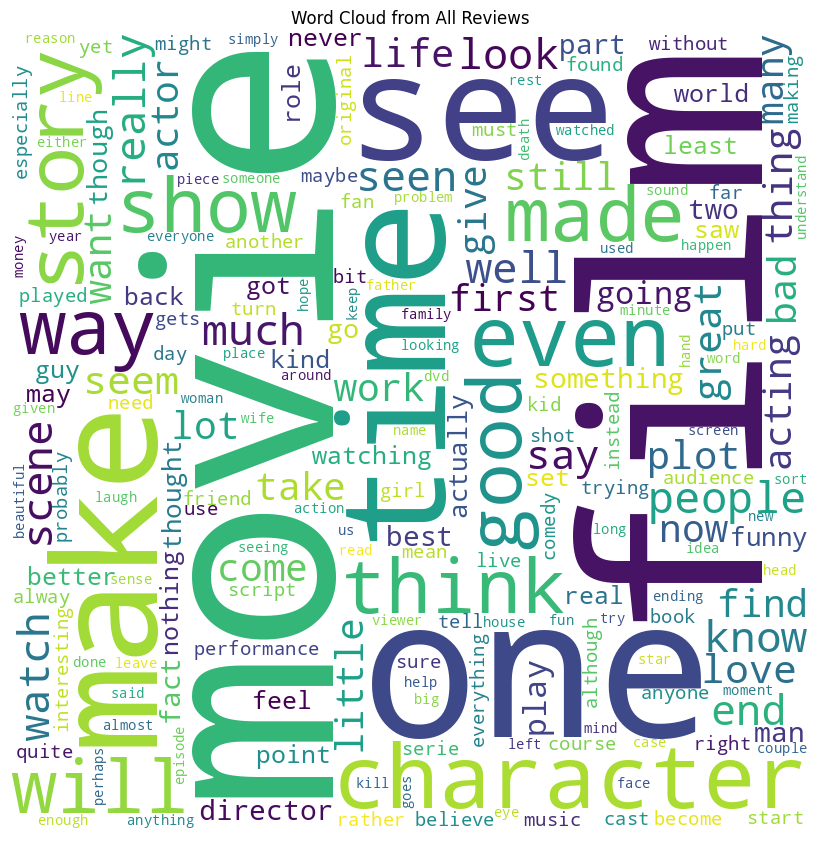

In [56]:
# plot the WordCloud image

import matplotlib.pyplot as plt

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Word Cloud from All Reviews")
plt.show()


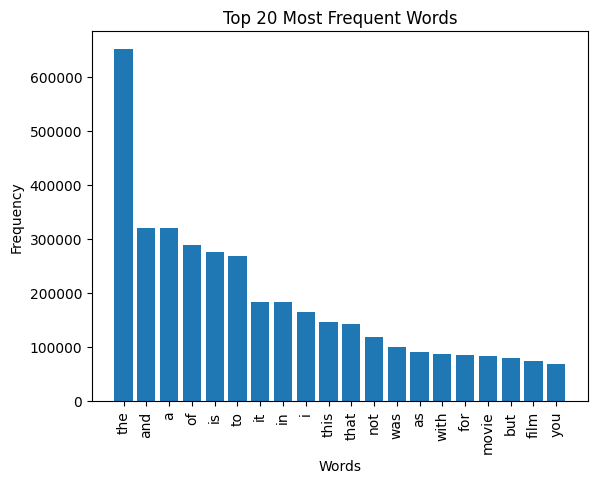

In [57]:
import re
from collections import Counter
import matplotlib.pyplot as plt


def create_barplot(string, k):
    # Step 1: Convert string to list of words
    words = string.split()

    # Step 2: Remove punctuation and special characters
    words = [re.sub(r'[^\w\s]', '', word) for word in words]

    # Step 3: Convert all words to lowercase
    words = [word.lower() for word in words]

    # Step 4: Count frequency of each word using dictionary
    word_counts = Counter(words)

    # Step 5: Sort dictionary by value in descending order and limit to top k
    sorted_word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True)[:k])

    # Step 6: Create barplot using matplotlib
    plt.bar(sorted_word_counts.keys(), sorted_word_counts.values())
    plt.xticks(rotation=90)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top {k} Most Frequent Words')
    plt.show()

k = 20

create_barplot(all_reviews, k)

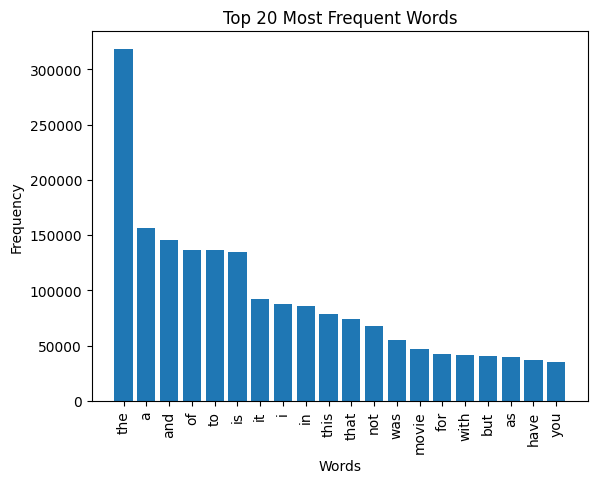

In [58]:
k = 20

create_barplot(negative_reviews, k)

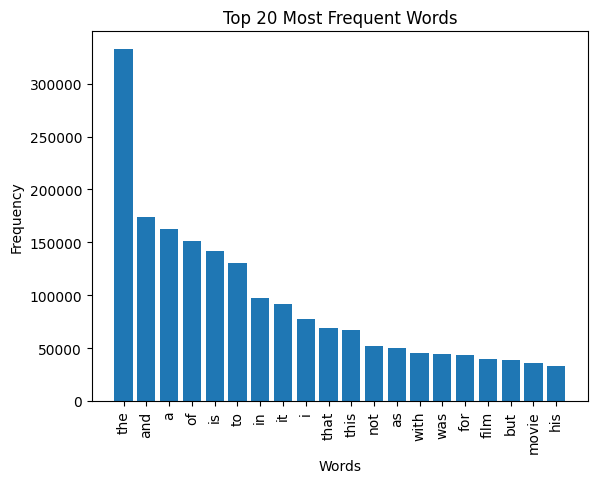

In [59]:
k = 20

create_barplot(positive_reviews, k)

In [60]:
# Define a function to count the number of words in a string
def count_words(text):
    return len(text.split())

# Apply the function to the reviews column using apply method
df['num_words'] = df['review'].apply(count_words)

# Create a new column in the dataframe with the number of words
df.head()

,review,sentiment,num_words
0,one of the other reviewers has mentioned that ...,positive,308
1,a wonderful little production. the filming tec...,positive,156
2,i thought this was a wonderful way to spend ti...,positive,164
3,basically there is a family where a little boy...,negative,135
4,"petter mattei's ""love in the time of money"" is...",positive,222


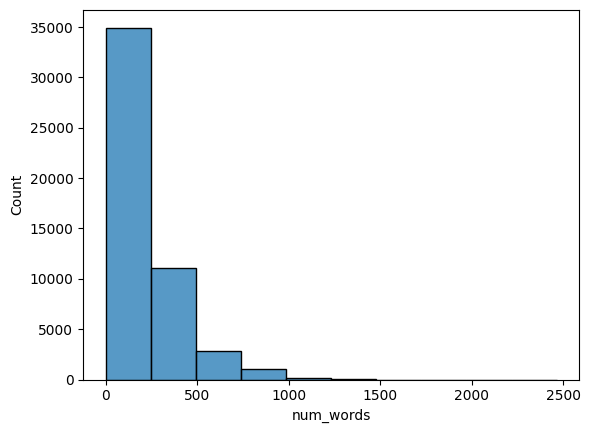

In [61]:
import seaborn as sns

# Create a histogram using seaborn's histplot function
sns.histplot(data=df, x='num_words', bins=10)

# Display the plots
plt.show()

<Axes: xlabel='num_words', ylabel='Density'>

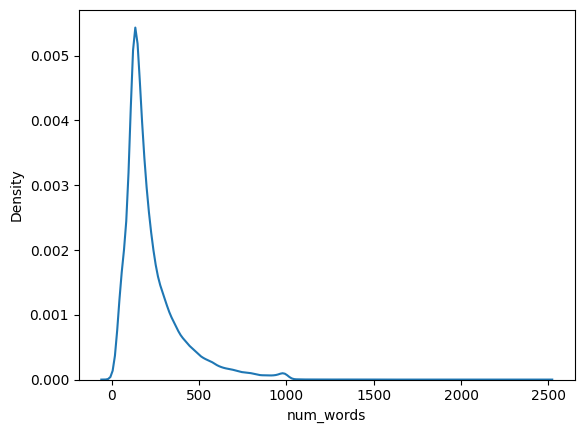

In [62]:

# Create a KDE plot using seaborn's kdeplot function
sns.kdeplot(data=df, x='num_words')


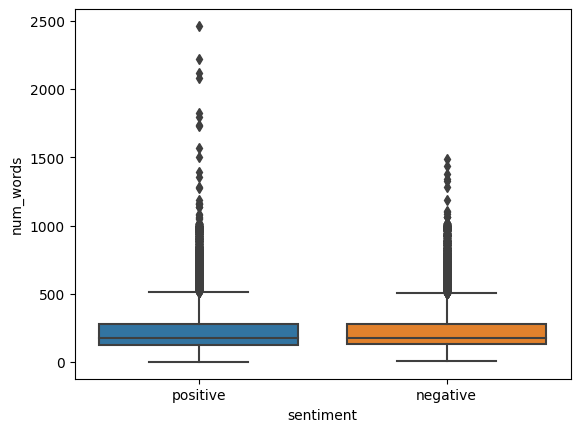

In [63]:
#  Create a grouped boxplot using seaborn's boxplot function
sns.boxplot(data=df, x='sentiment', y='num_words')

# Display the plot
plt.show()

## Create new numerical features in addition to the num_words, using sentence transformers to embed the text into fixed-length numerical representations

In [84]:
! pip install sentence-transformers

In [85]:
# Create a stratified random sample of df
strata = df['sentiment'].unique()

# Calculate the size of the sample for each stratum
sample_size = 2
sample_sizes = {s: sample_size for s in strata}

# Use pandas' groupby method to group the dataframe by the sentiment column
groups = df.groupby('sentiment')

# Use pandas' apply method to sample each group based on the size of the sample for that stratum
samples = groups.apply(lambda x: x.sample(n=sample_sizes[x.name])).reset_index(drop=True)

# Concatenate the sampled groups into a single dataframe
sampled_df = pd.concat([samples])

sampled_df

,review,sentiment,num_words
0,i truly was disappointed by this film which i ...,negative,437
1,it is quite rare that a movie comes along that...,negative,187
2,out of all the princess stories disney has put...,positive,394
3,this was truly a tense and dark episode. excel...,positive,103


In [86]:
import pandas as pd
from sentence_transformers import SentenceTransformer

# Load a pre-trained sentence transformer model
# model = SentenceTransformer('bert-base-nli-mean-tokens')
model = SentenceTransformer('bert-base-nli-mean-tokens', device='cuda')

# Define a function to embed the text using the sentence transformer model
def embed_text(text):
    embeddings = model.encode(text)
    return embeddings.tolist()

# Apply the function to the reviews column using apply method
sampled_df['embeddings'] = sampled_df['review'].apply(embed_text)

sampled_df

,review,sentiment,num_words,embeddings
0,i truly was disappointed by this film which i ...,negative,437,"[-0.6426070928573608, 0.8801245093345642, 0.16..."
1,it is quite rare that a movie comes along that...,negative,187,"[-0.07963324338197708, 0.7315586805343628, 0.1..."
2,out of all the princess stories disney has put...,positive,394,"[-0.46153804659843445, 0.6432949304580688, 0.3..."
3,this was truly a tense and dark episode. excel...,positive,103,"[-0.6954219341278076, 0.6282176375389099, 0.49..."


In [87]:
df_embeddings = pd.DataFrame(list(sampled_df['embeddings']))

sampled_df = pd.concat([sampled_df, df_embeddings], axis=1)
sampled_df.drop(['embeddings'], axis=1, inplace=True)

# df_model = sampled_df[['num_words', 0, 1, ..., 767]]

sampled_df

,review,sentiment,num_words,0,1,2,3,4,5,6,...,758,759,760,761,762,763,764,765,766,767
0,i truly was disappointed by this film which i ...,negative,437,-0.642607,0.880125,0.163443,-0.004932,-0.163360,-0.426846,0.851371,...,-0.297138,-0.930363,-1.507328,-1.841981,0.357467,-0.188499,0.181372,-0.096677,0.673889,-0.116257
1,it is quite rare that a movie comes along that...,negative,187,-0.079633,0.731559,0.176236,0.176053,-0.669285,-0.633571,1.672039,...,-0.121969,-0.400497,-0.865030,-2.053144,0.000475,-0.110986,0.299260,0.546863,0.414429,0.290834
2,out of all the princess stories disney has put...,positive,394,-0.461538,0.643295,0.396590,0.309495,-0.139649,-0.551248,1.138177,...,-0.640431,-1.028972,-0.782055,-1.186224,0.050526,-0.706904,0.252699,-0.423002,-0.286363,0.591545
3,this was truly a tense and dark episode. excel...,positive,103,-0.695422,0.628218,0.497110,0.422277,-0.524478,-0.898732,0.906624,...,-0.300649,-0.985053,-0.833140,-2.066457,-0.110379,-0.369450,0.331930,0.116246,0.628717,0.383176


In [88]:
modelReadDataset = sampled_df.drop(['review'], axis=1)
modelReadDataset['sentiment'] = modelReadDataset['sentiment'].astype('category')
modelReadDataset

,sentiment,num_words,0,1,2,3,4,5,6,7,...,758,759,760,761,762,763,764,765,766,767
0,negative,437,-0.642607,0.880125,0.163443,-0.004932,-0.163360,-0.426846,0.851371,-0.133859,...,-0.297138,-0.930363,-1.507328,-1.841981,0.357467,-0.188499,0.181372,-0.096677,0.673889,-0.116257
1,negative,187,-0.079633,0.731559,0.176236,0.176053,-0.669285,-0.633571,1.672039,0.143992,...,-0.121969,-0.400497,-0.865030,-2.053144,0.000475,-0.110986,0.299260,0.546863,0.414429,0.290834
2,positive,394,-0.461538,0.643295,0.396590,0.309495,-0.139649,-0.551248,1.138177,0.302451,...,-0.640431,-1.028972,-0.782055,-1.186224,0.050526,-0.706904,0.252699,-0.423002,-0.286363,0.591545
3,positive,103,-0.695422,0.628218,0.497110,0.422277,-0.524478,-0.898732,0.906624,-0.070969,...,-0.300649,-0.985053,-0.833140,-2.066457,-0.110379,-0.369450,0.331930,0.116246,0.628717,0.383176


## Classify the text after converting the response variable into a categorical type

In [106]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(random_state=42)

dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

## Create new numerical features in addition to the num_words, using sentence transformers to embed the text into fixed-length numerical representations

In [107]:
! pip install sentence-transformers

In [108]:
# Create a stratified random sample of df
strata = df['sentiment'].unique()

# Calculate the size of the sample for each stratum
sample_size = 2
sample_sizes = {s: sample_size for s in strata}

# Use pandas' groupby method to group the dataframe by the sentiment column
groups = df.groupby('sentiment')

# Use pandas' apply method to sample each group based on the size of the sample for that stratum
samples = groups.apply(lambda x: x.sample(n=sample_sizes[x.name])).reset_index(drop=True)

# Concatenate the sampled groups into a single dataframe
sampled_df = pd.concat([samples])

sampled_df

,review,sentiment,num_words
0,"back in the days before the toxic avenger, the...",negative,363
1,i consider myself a big fan of low budget horr...,negative,301
2,what would it be like to be accused of being a...,positive,77
3,i have to say that this film was excellently p...,positive,134


In [109]:
import pandas as pd
from sentence_transformers import SentenceTransformer

# Load a pre-trained sentence transformer model
# model = SentenceTransformer('bert-base-nli-mean-tokens')
model = SentenceTransformer('bert-base-nli-mean-tokens', device='cuda')

# Define a function to embed the text using the sentence transformer model
def embed_text(text):
    embeddings = model.encode(text)
    return embeddings.tolist()

# Apply the function to the reviews column using apply method
sampled_df['embeddings'] = sampled_df['review'].apply(embed_text)

sampled_df

,review,sentiment,num_words,embeddings
0,"back in the days before the toxic avenger, the...",negative,363,"[0.07266625761985779, 0.6082674860954285, 0.66..."
1,i consider myself a big fan of low budget horr...,negative,301,"[-0.2643967270851135, 0.7923219203948975, 0.24..."
2,what would it be like to be accused of being a...,positive,77,"[-0.20630404353141785, 0.7119168043136597, -0...."
3,i have to say that this film was excellently p...,positive,134,"[-0.3142739534378052, -0.009776581078767776, 0..."


In [110]:
df_embeddings = pd.DataFrame(list(sampled_df['embeddings']))

sampled_df = pd.concat([sampled_df, df_embeddings], axis=1)
sampled_df.drop(['embeddings'], axis=1, inplace=True)

# df_model = sampled_df[['num_words', 0, 1, ..., 767]]

sampled_df

,review,sentiment,num_words,0,1,2,3,4,5,6,...,758,759,760,761,762,763,764,765,766,767
0,"back in the days before the toxic avenger, the...",negative,363,0.072666,0.608267,0.660993,0.293613,-0.443893,-0.198202,0.847820,...,-0.299976,-0.688762,-1.415497,-1.879673,0.058897,-0.114945,0.144362,0.101776,0.516277,0.175179
1,i consider myself a big fan of low budget horr...,negative,301,-0.264397,0.792322,0.246476,0.160809,-0.135003,-0.581989,0.560478,...,-0.663415,-1.160763,-1.595349,-1.756096,-0.086903,-0.821184,0.233050,-0.015274,0.895067,0.174011
2,what would it be like to be accused of being a...,positive,77,-0.206304,0.711917,-0.362323,0.178237,-0.197283,-0.099412,1.050003,...,-0.077492,-0.262889,-0.699722,-1.313535,-0.271727,-0.130131,0.032919,-0.227807,0.183172,-0.013906
3,i have to say that this film was excellently p...,positive,134,-0.314274,-0.009777,0.014139,0.165672,-0.248702,-1.071682,0.137949,...,-0.274459,-1.057270,-1.064229,-2.195034,-0.332444,0.018519,0.427975,-0.324269,0.499802,-0.031411


In [111]:
modelReadDataset = sampled_df.drop(['review'], axis=1)
modelReadDataset['sentiment'] = modelReadDataset['sentiment'].astype('category')
modelReadDataset

,sentiment,num_words,0,1,2,3,4,5,6,7,...,758,759,760,761,762,763,764,765,766,767
0,negative,363,0.072666,0.608267,0.660993,0.293613,-0.443893,-0.198202,0.847820,0.103671,...,-0.299976,-0.688762,-1.415497,-1.879673,0.058897,-0.114945,0.144362,0.101776,0.516277,0.175179
1,negative,301,-0.264397,0.792322,0.246476,0.160809,-0.135003,-0.581989,0.560478,-0.120157,...,-0.663415,-1.160763,-1.595349,-1.756096,-0.086903,-0.821184,0.233050,-0.015274,0.895067,0.174011
2,positive,77,-0.206304,0.711917,-0.362323,0.178237,-0.197283,-0.099412,1.050003,0.087154,...,-0.077492,-0.262889,-0.699722,-1.313535,-0.271727,-0.130131,0.032919,-0.227807,0.183172,-0.013906
3,positive,134,-0.314274,-0.009777,0.014139,0.165672,-0.248702,-1.071682,0.137949,-0.231904,...,-0.274459,-1.057270,-1.064229,-2.195034,-0.332444,0.018519,0.427975,-0.324269,0.499802,-0.031411


## Classify the text after converting the response variable into a categorical type

In [112]:
# Create a decision tree to classify sentiment using the remaining columns of modelReadDataset
modelReadDataset = modelReadDataset.drop(['num_words'], axis=1)

from sklearn.model_selection import train_test_split

X = modelReadDataset.drop('sentiment', axis=1)
y = modelReadDataset['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [113]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(random_state=42)

dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [114]:
# https://docs.google.com/spreadsheets/d/1VK-Zs72ebK6ddwvDYFN2cA04PDTbVLXJeylmdJ7OxkM/edit#gid=1517061328

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

worksheet = gc.open('PGSS2023').get_worksheet(5) #CrowdSourcedSentimentData

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
print(rows)

# Convert to a DataFrame and render.
import pandas as pd
newDf = pd.DataFrame.from_records(rows[1:])

newDf.columns = rows[0]

newDf

[['Name', 'review', 'sentiment'], ['Parth Parikh', 'On Saturday, friends and I went to the Kennywood amusement park and enjoyed riding various roller coasters. After returning, I had a great time continuing to hang out on campus.', 'Positive'], ['Ben Nguyen', 'We cheated at the Arcade and lost $60', 'Negative'], ['Felix Yang', 'We went to Kennywood, it was fun and great', 'Positive'], ['Sooraj Tharumia', 'We got Github CoPilot to install on the local development environment.', 'Positive'], ['Helen Mao', "I can't escape the country accent.", 'Negative'], ['Kamya Rajesh', 'I slept in, watched a movie, had boba, and walked around with my friends.', 'Positive'], ['Yanwei Liu', 'I walked with friends to a crepe shop, but it was closed. We were so sad.', 'Negative'], ['Olina Mukherjee', 'we made Mega Bed and had a sleepover with 10 people in one AC-ed room, it was fun', 'Positive'], ['Lihini Ranaweera', 'My friends and I went to Kennywood and had fun. We decorated a cake and enjoyed it. ', '

,Name,review,sentiment
0,Parth Parikh,"On Saturday, friends and I went to the Kennywo...",Positive
1,Ben Nguyen,We cheated at the Arcade and lost $60,Negative
2,Felix Yang,"We went to Kennywood, it was fun and great",Positive
3,Sooraj Tharumia,We got Github CoPilot to install on the local ...,Positive
4,Helen Mao,I can't escape the country accent.,Negative
5,Kamya Rajesh,"I slept in, watched a movie, had boba, and wal...",Positive
6,Yanwei Liu,"I walked with friends to a crepe shop, but it ...",Negative
7,Olina Mukherjee,we made Mega Bed and had a sleepover with 10 p...,Positive
8,Lihini Ranaweera,My friends and I went to Kennywood and had fun...,Positive
9,Kofi Anokye,Slept more than 6 hours,Positive


## Load new model (non-imdb from here on out except referencing imdb model)

In [115]:
# Load the model from the pkl file
import pickle

with open('/content/gdrive/MyDrive/PGSS2023/Week 02/dt_model.pkl', 'rb') as f:
    dt_classifier = pickle.load(f)

dt_classifier

DecisionTreeClassifier(random_state=42)

## Engineer the features that the model needs

In [116]:
! pip install sentence-transformers

In [117]:
# Define a function to count the number of words in a string
def count_words(text):
    return len(text.split())

# Apply the function to the reviews column using apply method
newDf['num_words'] = newDf['review'].apply(count_words)

newDf["review"] = newDf["review"].str.lower()

newDf.rename(columns={'num_words': 761}, inplace=True)

import pandas as pd
from sentence_transformers import SentenceTransformer

# Load a pre-trained sentence transformer model
# model = SentenceTransformer('bert-base-nli-mean-tokens')
model = SentenceTransformer('bert-base-nli-mean-tokens', device='cuda')

# Define a function to embed the text using the sentence transformer model
def embed_text(text):
    embeddings = model.encode(text)
    return embeddings.tolist()

# Apply the function to the reviews column using apply method
newDf['embeddings'] = newDf['review'].apply(embed_text)

df_embeddings = pd.DataFrame(list(newDf['embeddings']))

newDf = pd.concat([newDf, df_embeddings], axis=1)
newDf.drop(['embeddings'], axis=1, inplace=True)

# Make the words in "sentiment" column lower-case
newDf["review"] = newDf["review"].str.lower()
newDf["sentiment"] = newDf["sentiment"].str.lower()

newDf

,Name,review,sentiment,761,0,1,2,3,4,5,...,758,759,760,761,762,763,764,765,766,767
0,Parth Parikh,"on saturday, friends and i went to the kennywo...",positive,30,-0.236651,-0.411669,1.803870,0.502376,0.056640,-1.442143,...,-0.458309,-1.342463,-1.151225,-0.869811,0.571280,-2.087172,-0.119997,0.238306,-0.044361,-0.240646
1,Ben Nguyen,we cheated at the arcade and lost $60,negative,8,0.171415,0.616539,-0.202054,0.811134,0.370447,0.262969,...,-0.315388,0.073051,-0.770700,-0.399417,1.135651,-0.010402,-0.308450,-0.420459,0.444750,0.080028
2,Felix Yang,"we went to kennywood, it was fun and great",positive,9,0.093172,-0.034284,1.983440,0.138529,-0.225989,-1.127789,...,-0.410948,-1.585070,-0.316526,-1.516949,-0.136290,-1.147071,-0.361482,0.407926,0.064288,-0.198978
3,Sooraj Tharumia,we got github copilot to install on the local ...,positive,11,0.401379,0.230450,1.246814,0.516489,0.259700,-0.140194,...,-0.546583,-0.560267,-1.407246,-0.154892,0.023543,-0.709044,-0.427847,-0.272633,-0.581324,0.216744
4,Helen Mao,i can't escape the country accent.,negative,6,0.092309,0.296268,1.460296,0.507051,0.305698,0.545499,...,-0.626227,-0.733478,0.323088,-0.601730,-0.092325,-1.092104,0.505501,0.729472,-0.260707,0.409460
5,Kamya Rajesh,"i slept in, watched a movie, had boba, and wal...",positive,14,0.510924,0.689157,1.570543,-0.377628,-0.166212,-0.482224,...,0.023850,-0.709443,-0.617774,-0.527576,1.099379,-0.469343,0.315280,1.062005,0.983859,-0.243286
6,Yanwei Liu,"i walked with friends to a crepe shop, but it ...",negative,16,-0.165044,0.536896,1.078410,-0.229326,-0.227582,0.793055,...,0.080410,-1.047962,-1.118609,-1.558059,0.734870,-1.059605,-0.329513,0.827436,-0.415041,-0.183259
7,Olina Mukherjee,we made mega bed and had a sleepover with 10 p...,positive,18,-0.143872,0.736027,0.037365,0.281454,0.494500,-1.076953,...,-0.851258,-1.161659,-0.581674,-0.447503,0.525668,-0.141608,0.625408,0.104810,1.221338,-0.424296
8,Lihini Ranaweera,my friends and i went to kennywood and had fun...,positive,17,-0.505824,0.684451,0.988027,-0.128968,-0.839170,-0.631768,...,-0.923227,-2.282973,-0.839400,-1.330241,0.308691,-0.934405,0.053562,0.271991,-0.229564,0.242981
9,Kofi Anokye,slept more than 6 hours,positive,5,0.568165,-0.146791,0.744467,0.358526,0.210618,-0.448313,...,0.404829,0.027615,0.257842,0.187654,1.013081,-0.407390,-0.252731,-0.399876,0.951630,-0.782845


## Evaluate the trained model on the new data



In [102]:
from sklearn import metrics

y_pred = dt_classifier.predict(newDf.drop(['sentiment','Name','review'], axis=1))

print('Accuracy:', metrics.accuracy_score(newDf['sentiment'].values, y_pred))

Accuracy: 0.4117647058823529


In [103]:
from sklearn.metrics import classification_report

report = classification_report(newDf['sentiment'].values, y_pred, target_names=['negative', 'positive'])
print(report)


              precision    recall  f1-score   support

    negative       0.22      0.40      0.29         5
    positive       0.62      0.42      0.50        12

    accuracy                           0.41        17
   macro avg       0.42      0.41      0.39        17
weighted avg       0.51      0.41      0.44        17

